# Aplicación de técnicas de IA al problema de "bin packing"

## Descripción del problema

Para este trabajo se ha elegido un problema del tipo "bin packing", esto es, de colocación de N piezas de diferentes tamaños en mínimo número de contendores de capacidad C fija. Se trata por tanto de un problema de optimización del espacio utilizado, con amplias y muy útiles aplicaciones en el mundo real, como por ejemplo la colocación de material en almacenes o de mercancías en camiones y barcos.

En cuanto al diseño del problema, se ha optado por piezas rectangulares con ancho fijo y altura variable. En cuanto a los contenedores, tienen el mismo ancho que las piezas, de manera que las piezas se colocan una encima de otra sin dejar espacio en los laterales. Esto simplifica bastante la representación del problema en un "código" apto para la aplicación de técnicas de IA, y permite centrarse en los detalles de estas últimas. El problema se reduce a la elección del orden en que las N piezas deben introducirse de manera que, colocándose una encima de otra y sin sobrepasar la altura de los contenedores, utilicen el mínimo número de estos (o que desperdicien el mínimo número de espacio en cada uno de ellos). Para la elección del "fitness" se barajaron estas dos alternativas, pero se optó por el número de espacio desperdiciado por ofrecer una mayor variabilidad.

La nomenclatura utilizada es la siguiente:

* Número de piezas a colocar (`N`)
* Contenedor (`bin`) de altura fija (`bin_size` de tipo entero), representado por una matriz de dimensiones `(1, bin_size)`. El valor inicial de las celdas de los contendores es 0
* Piezas (`figures`) representadas por su altura (de tipo entero, valor mínimo 1 y valor máximo 70% de bin_size), cuyo orden de introducción viene representado por el orden de aparición en una lista de longitud `N`
* Solución (`bins`), representada por una matriz de dimensiones `(x, bin_size)`, donde `x` es el número de contendores necesarios para colocar todas las piezas. La suma de los elementos de cada una de las filas nunca puede exceder `bin_size`
* Función `fitness`, que evalúa el número contenedores utilizados en la solución

Se ha elegido realizar y presentar el presente proyecto en forma de notebooks de Jupyter implementados en el lenguaje de programación Python.

Tras una configuración inicial, se pasará a describir las diferentes técnicas de IA utilizadas.

In [1]:
!apt-get -y install texlive-latex-extra texlive-fonts-recommended dvipng cm-super texlive-fonts-extra




texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-fonts-recommended set to manually installed.
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-extra
  fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia
  fonts-gfs-complutum fonts-gfs-didot fonts-gfs-neohellenic fonts-gfs-olga
  fonts-gfs-solomos fonts-go fonts-junicode fonts-linuxlibertine fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-oflb-asana-math fonts-open-sans
  fonts-roboto-hinted fonts-sil-gentium fonts-sil-gentium-basic
  fonts-sil-gentiumplus fonts-sil-gentiumplus-compact fonts-stix pfb2t1c2pf

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

## Definición de funciones auxiliares

* `generate_figures`: como su nombre indica, la función retorna una lista de `n` piezas generadas de forma aleatoria, con valor de tipo entero, mínimo de 1 y valor máximo de 70% de `bin_size`
* `place`: esta función traduce una lista de piezas con un orden determinado, en una solución `bins`. En nomenclatura de algoritmos genéticos, es la conversión del genotipo en su fenotipo
* `fitness`: es la función de evaluación que, como se ha dicho anteriormente, mide la cantidad de espacio desperdiciado en los contendores que forman parte de una solución
* `theoretical_optimum`: calcula el número óptimo de contendores a utilizar para colocar todas las piezas (puede que sea imposible de alcanzar, pero ayuda a saber lo buena o mala que es una solución)
* `plot_bins`: genera una representación visual de una solución utilizando un diagrama de barras apiladas

In [3]:
def generate_figures(bin_size, n):
    figure_max_value = int(bin_size * 0.7)
    np_figures = np.random.randint(figure_max_value, size=(n)) + 1
    return np_figures.tolist()

def place(bin_size, figures):
    bins = np.zeros((1,bin_size), dtype=int)
    current_bin_index = 0;
    current_bin = np.zeros(bin_size, dtype=int)
    current_bin_count = 0
    for figure in figures:
        if current_bin_count + figure > bin_size:
            if current_bin_index == 0:
                bins[0] = current_bin
            else:
                bins = np.insert(bins, current_bin_index, current_bin, 0)
            current_bin_index += 1
            current_bin = np.zeros(bin_size, dtype=int)
            current_bin_count = 0
        for i in range(bin_size):
            if current_bin[i] == 0:
                current_bin[i] = figure
                break;
        current_bin_count += figure
    if len(current_bin) > 0:
        bins = np.insert(bins, current_bin_index, current_bin, 0)
    return bins

def fitness(bins):
    return len(bins)

def theoretical_optimum(bin_size, figures):
    count = 0
    holes_count = 0
    less_or_equal_than_half_figures_sum = 0
    for figure in figures:
        if figure > bin_size / 2:
            count += 1
            holes_count += bin_size - figure
        else:
            less_or_equal_than_half_figures_sum += figure
    diff = less_or_equal_than_half_figures_sum - holes_count
    if (diff > 0):
        count += math.ceil(diff / bin_size)
    return count

def plot_bins(bins):
    transposed_bins = bins.transpose()
    
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    plt.figure(figsize=(20, 5))
    
    ind = range(len(bins))
    for i in range(len(transposed_bins)):
        plt.bar(ind, transposed_bins[i], color=colors[i%len(colors)], bottom=np.sum(transposed_bins[0:i,:], axis=0))
        
    plt.show()

### Ejemplo (`bin_size = 10` y `N = 20`)

Para contenedores de tamaño 10, y una lista de 20 piezas, se puede observar cuál es el resultado de cada una de las funciones descritas anteriormente:

[4, 1, 2, 3, 5, 6, 3, 2, 1, 6, 1, 3, 1, 6, 7, 6, 7, 2, 3, 3]
Theoretical optimum:  8
Fitness:  9


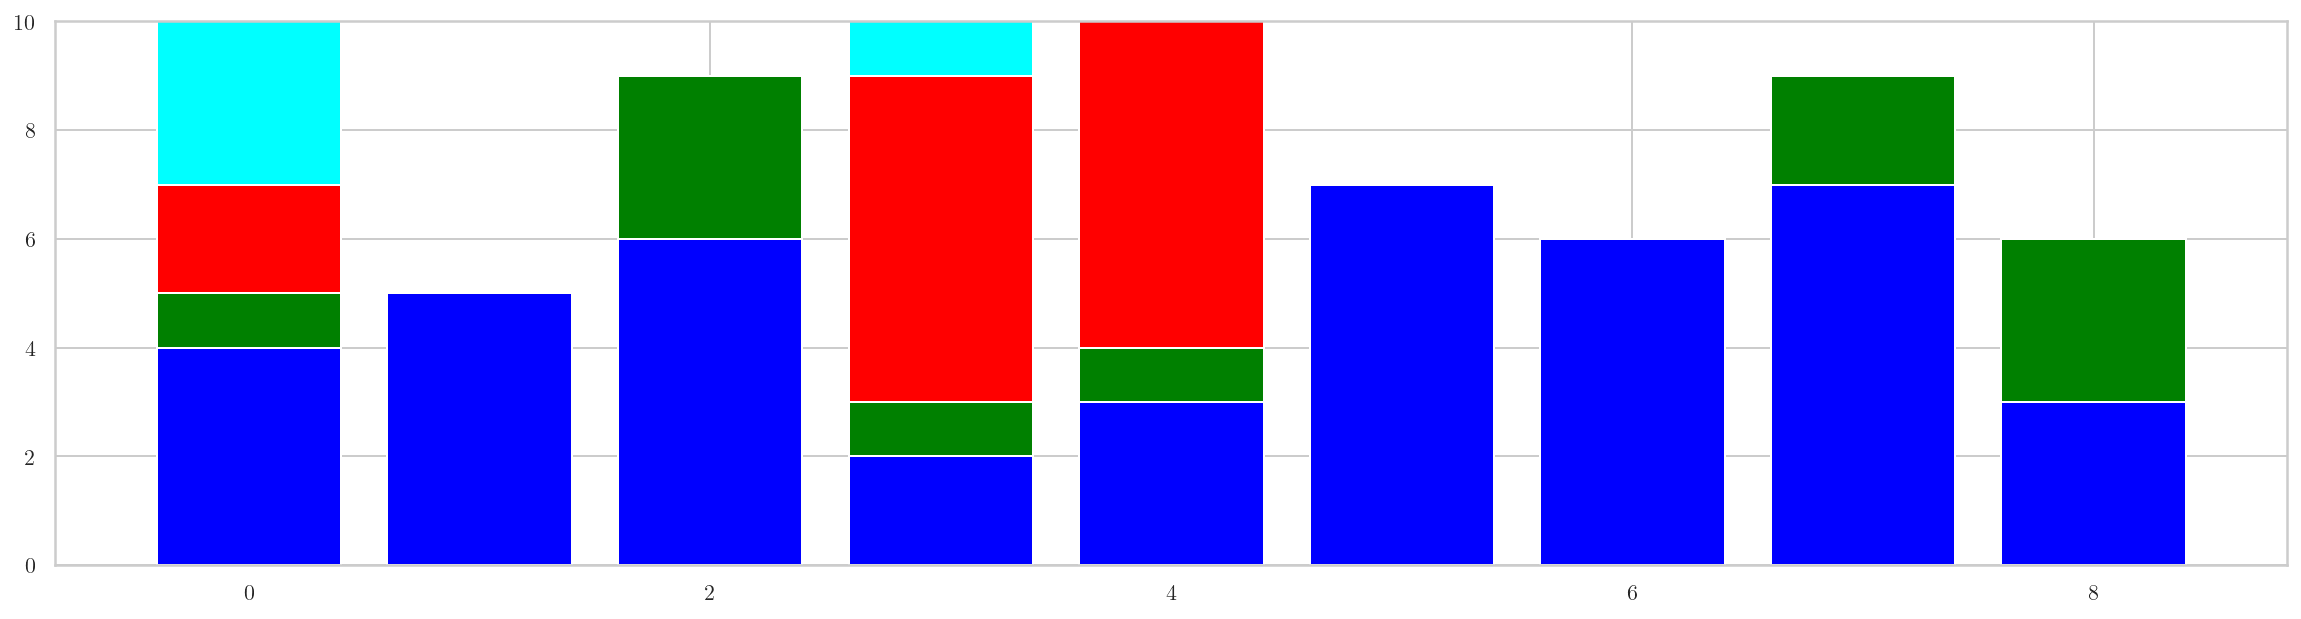

In [4]:
bin_size = 10
figures = generate_figures(bin_size, 20)
print(figures)
print('Theoretical optimum: ', theoretical_optimum(bin_size, figures))
bins = place(bin_size, figures)
print('Fitness: ', fitness(bins))
plot_bins(bins)

### Ejemplo (`bin_size = 100` y `N = 500`)

Para observar un problema mucho más exigente, se aumenta `bin_size` a 100 y `N` a 500:

In [5]:
bin_size = 100
figures = generate_figures(bin_size, 500)
print(figures)
print('Theoretical optimum: ', theoretical_optimum(bin_size, figures))

[20, 46, 70, 50, 63, 43, 28, 21, 32, 36, 5, 53, 56, 26, 63, 52, 57, 48, 52, 51, 67, 38, 18, 30, 46, 18, 51, 8, 13, 32, 16, 48, 20, 41, 41, 19, 51, 25, 13, 32, 34, 15, 52, 37, 45, 27, 4, 42, 49, 58, 23, 57, 48, 54, 50, 26, 48, 66, 65, 70, 47, 47, 25, 59, 34, 50, 6, 42, 2, 31, 21, 48, 26, 22, 56, 37, 48, 70, 51, 14, 28, 19, 53, 59, 33, 7, 36, 24, 65, 44, 55, 25, 12, 21, 62, 18, 44, 29, 12, 3, 24, 34, 24, 70, 16, 52, 51, 21, 33, 13, 67, 57, 41, 17, 13, 3, 62, 67, 63, 53, 43, 54, 61, 61, 42, 34, 70, 46, 16, 40, 62, 58, 31, 69, 33, 16, 20, 55, 57, 51, 42, 24, 16, 13, 61, 61, 21, 68, 42, 1, 61, 55, 62, 23, 43, 17, 37, 50, 13, 51, 58, 28, 54, 22, 66, 8, 49, 8, 47, 26, 57, 61, 3, 5, 62, 41, 53, 54, 64, 52, 70, 56, 59, 4, 23, 44, 30, 7, 12, 45, 29, 29, 25, 13, 28, 11, 27, 54, 46, 69, 38, 17, 16, 3, 58, 43, 6, 64, 62, 65, 53, 68, 57, 26, 22, 22, 21, 3, 60, 5, 41, 11, 41, 70, 36, 35, 63, 46, 15, 47, 67, 2, 24, 30, 1, 54, 21, 24, 12, 47, 49, 48, 7, 9, 16, 70, 19, 4, 55, 12, 5, 51, 15, 32, 66, 70, 

Fitness:  252


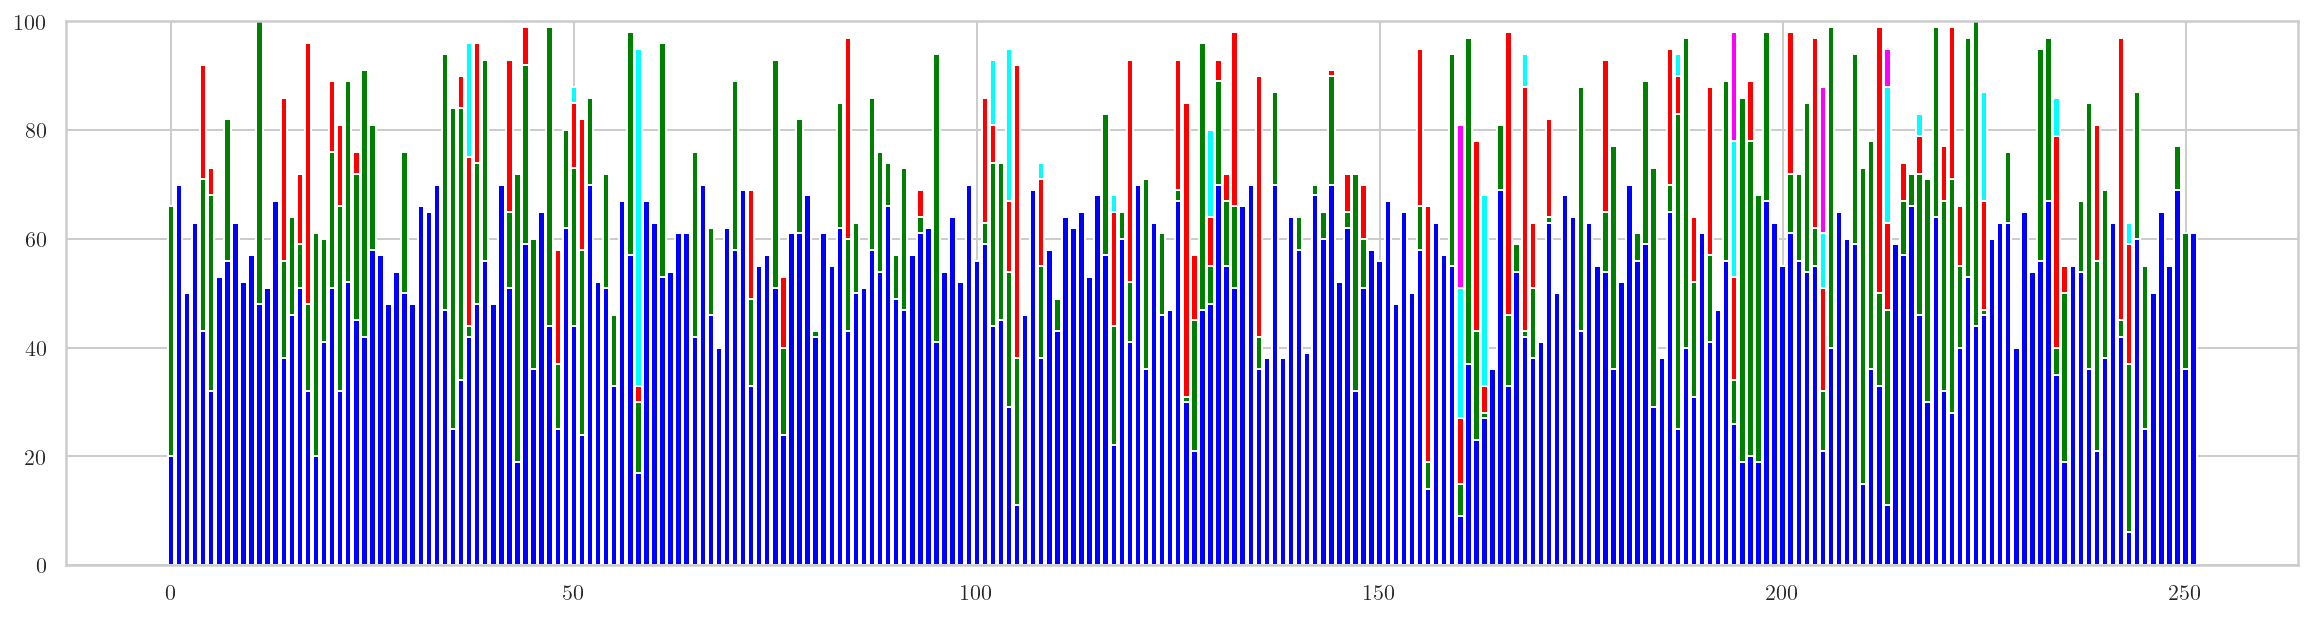

In [6]:
bins = place(bin_size, figures)
print('Fitness: ', fitness(bins))
plot_bins(bins)

### Ejemplo de optimización sin técnicas de IA

Analizando el problema, se pueden definir heurísticas que mejoran el fitness de una lista de figuras ordenándolas de forma mínimamente razonada, sin necesidad de aplicar metaheurísticas. Por ejemplo, y se trata solo de un ejemplo, con la siguiente estrategia de ordenación:

In [7]:
def two_low_one_high_sort_strategy(figures):
    sorted_figures = figures.copy()
    sorted_figures.sort()
    aux_figures = []
    j = 0
    k = len(figures) - 1
    while j < k:
        aux_figures.append(sorted_figures[j])
        j += 1
        if (j % 2 == 0):
            aux_figures.append(sorted_figures[k])
            k -= 1
    return aux_figures

Fitness:  217


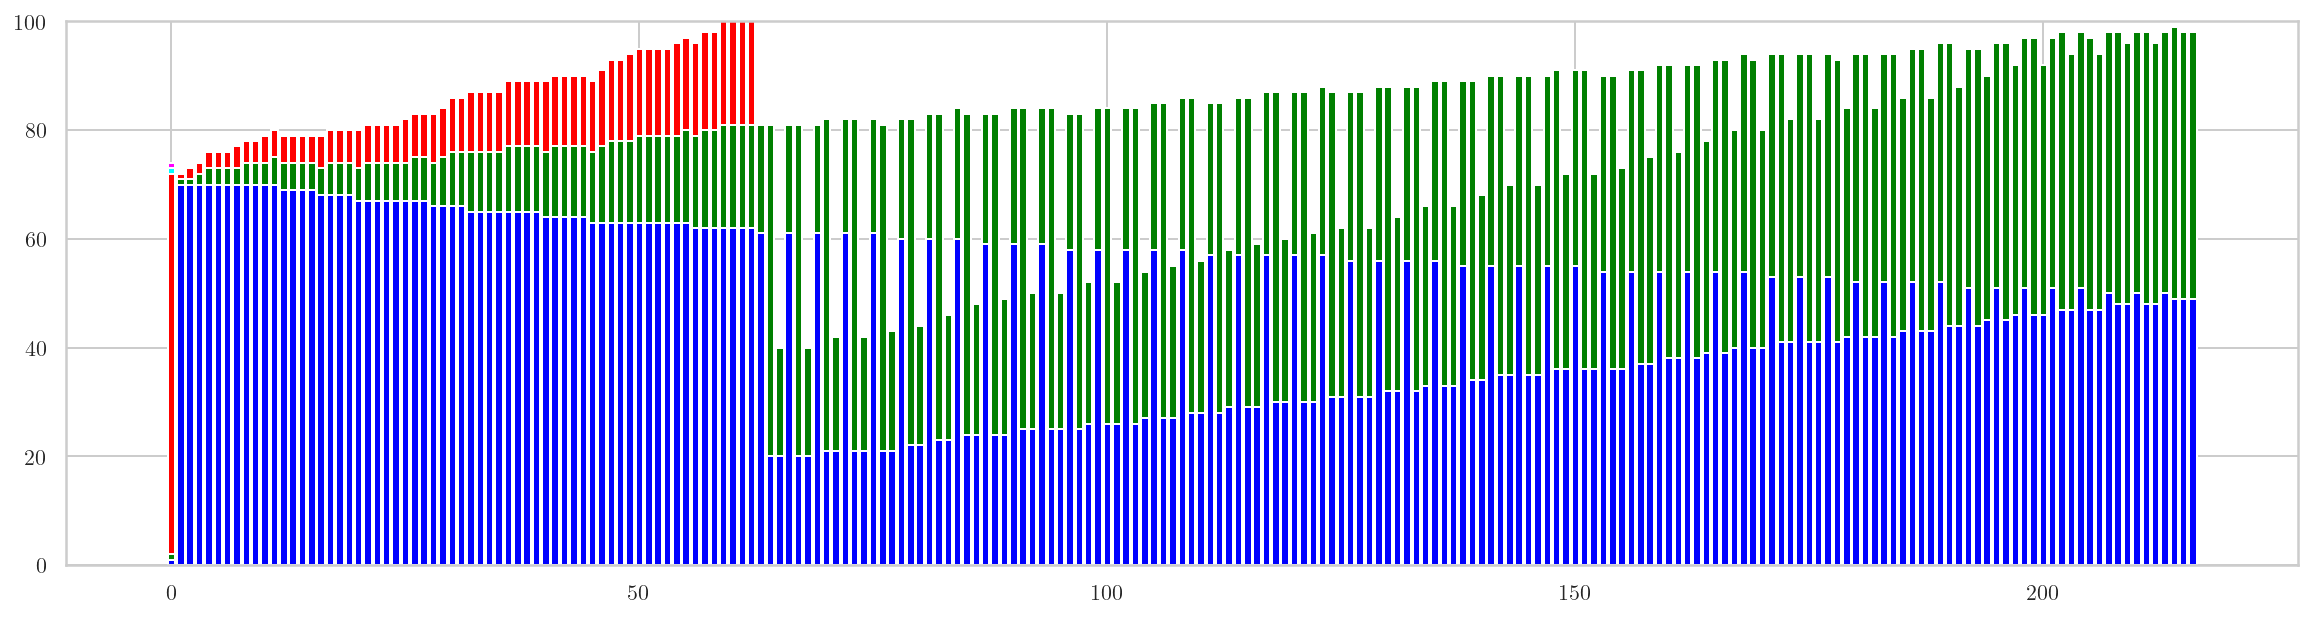

In [8]:
bins = place(bin_size, two_low_one_high_sort_strategy(figures))
print('Fitness: ', fitness(bins))
plot_bins(bins)

## Algoritmos genéticos

Para la aplicación de algoritmos genéticos al problema, se ha optado por utilizar la librería [DEAP](https://github.com/DEAP/deap).

In [9]:
from deap import algorithms, base, creator, tools

toolbox = base.Toolbox()

Se define que el objetivo es minimizar el resultado de la función fitness, y que un individuo (que representa una posible solución al problema) está representado por una lista:

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Aquí se define que los individuos están compuestos por índices que hacen referencia a los elementos de `figures`, y que la población está compuesta por un conjunto de individuos:

In [11]:
toolbox.register("indices", np.random.permutation, len(figures))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

Como operadores de cruce y mutación, se han escogido la funciones [cxOrdered](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered) y [mutShuffleIndexes](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes) de la librería DEAP, ya que ambas están diseñadas para trabajar con secuencias de índices:

In [12]:
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("mate", tools.cxOrdered)

La evaluación de un individuo se calcula utilizando las funciones `create_bins` y `evaluation` definidas a continuación:

In [13]:
def create_bins(individual):
    return place(bin_size, [list(figures)[i] for i in individual])

def evaluation(individual):
    return (fitness(create_bins(individual)),)

toolbox.register("evaluate", evaluation)

Para poder observar cómo evoluciona el fitness de la población a lo largo del proceso, se configuran las siguientes estadísticas que el algoritmo recogerá:

In [14]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

### Experimento 1

* Operador de selección: torneo de tamaño 3
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 80%
* Probabilidad de mutación: 20%

In [15]:
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=100)

In [16]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 6min 51s, sys: 421 ms, total: 6min 52s
Wall time: 7min


In [17]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  207


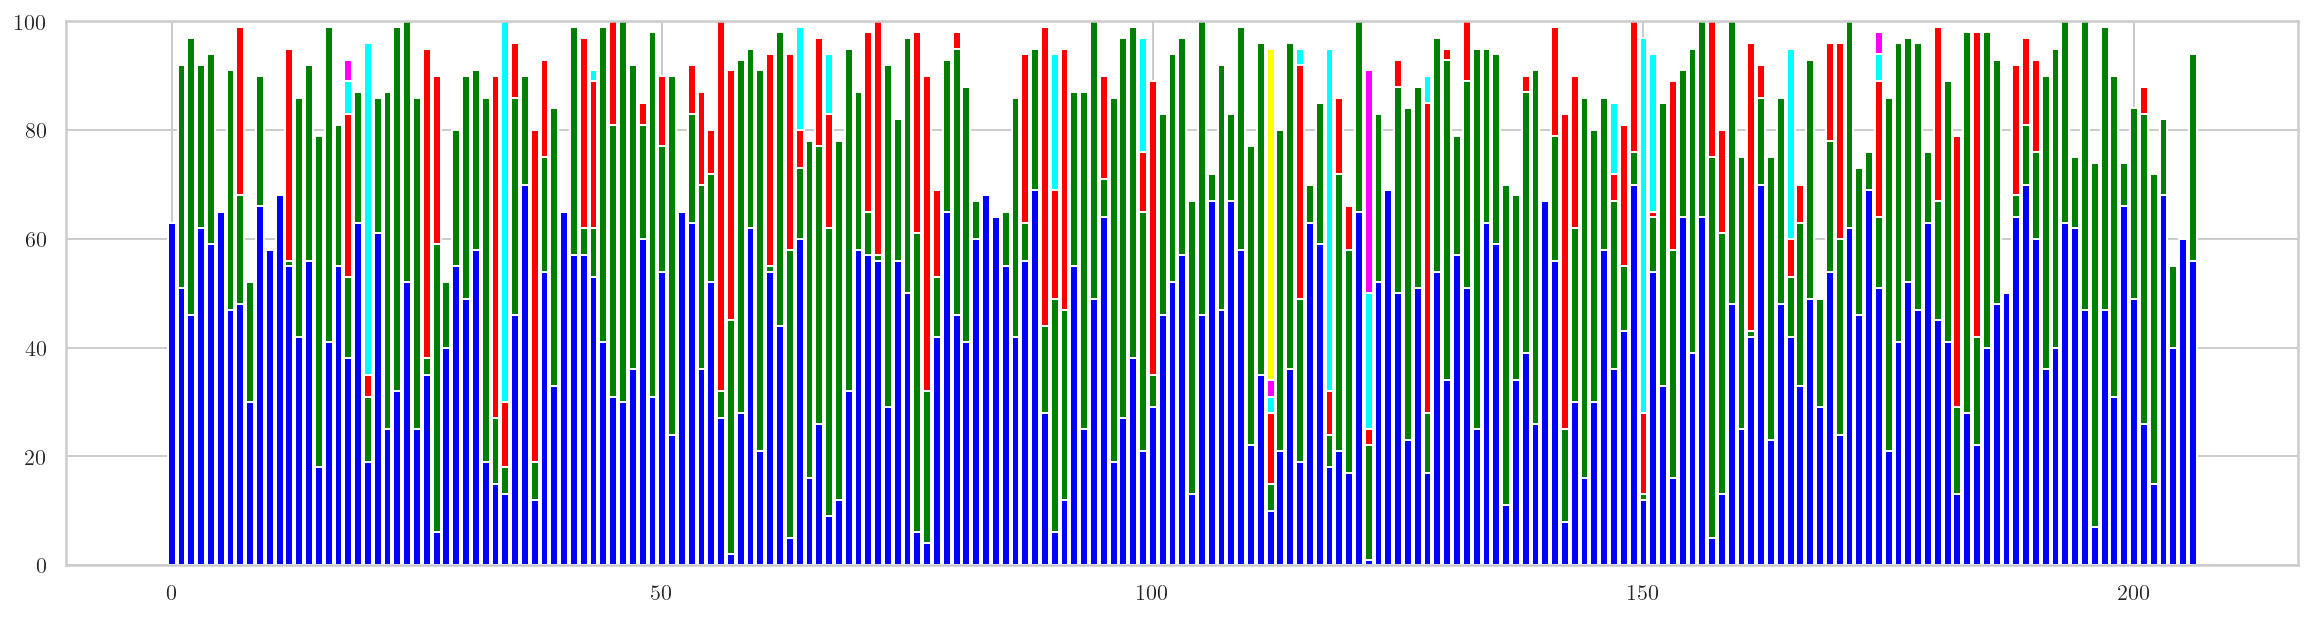

In [18]:
plot_bins(create_bins(best_individual))

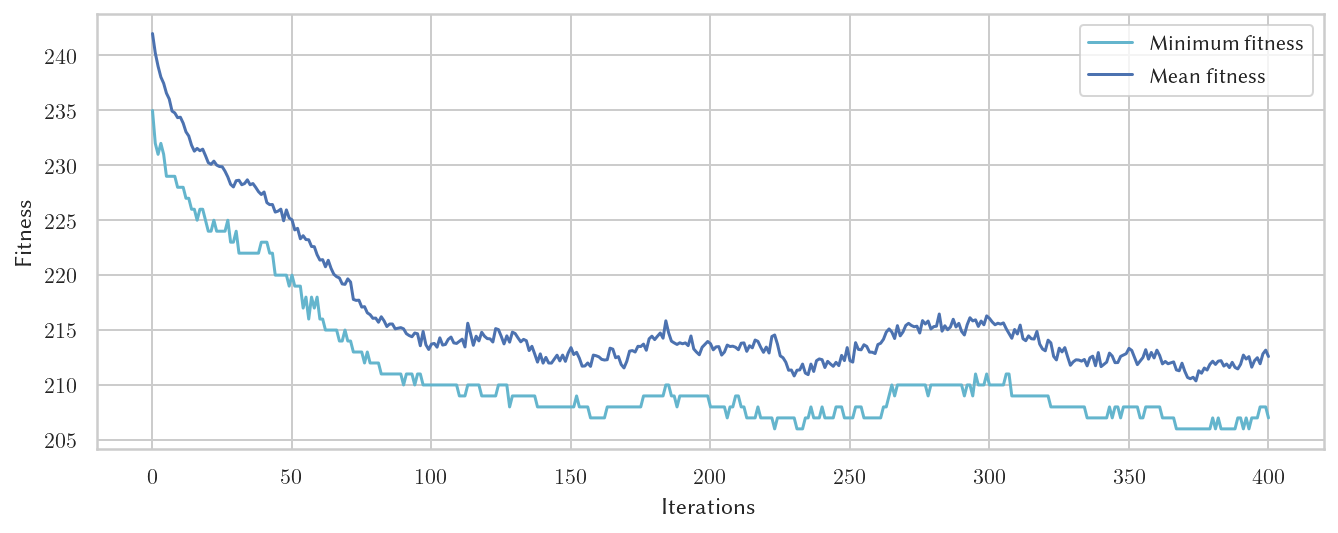

In [19]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### Experimento 2

* Operador de selección: torneo de tamaño 3
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 80%
* Probabilidad de mutación: 5%

In [20]:
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=100)

In [21]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.05,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 6min 35s, sys: 360 ms, total: 6min 35s
Wall time: 6min 42s


In [22]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  205


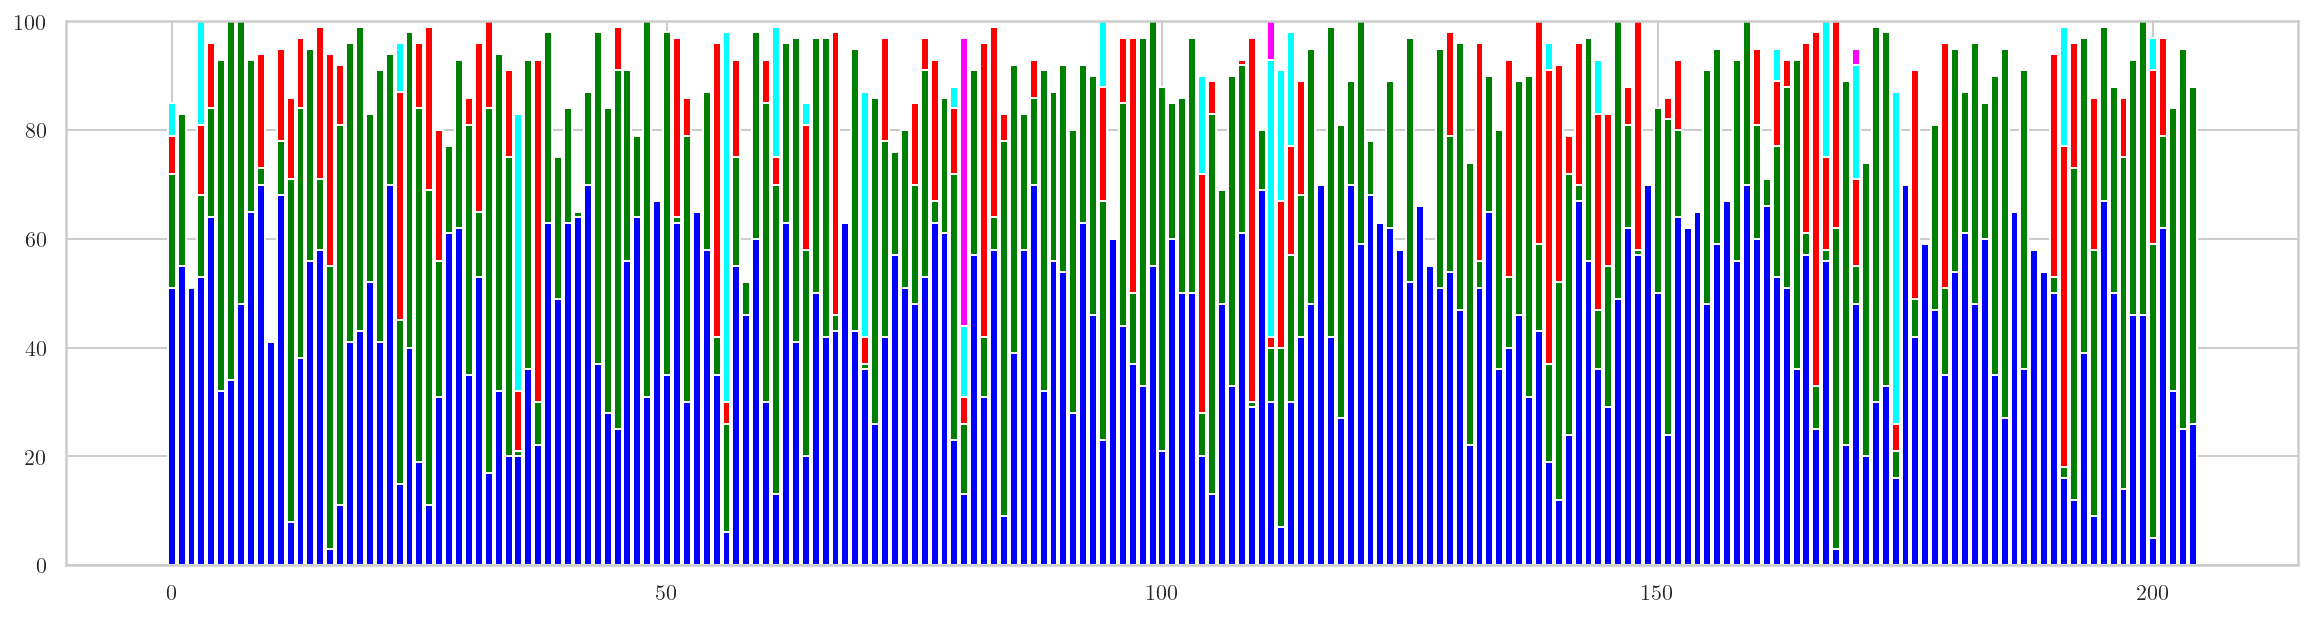

In [23]:
plot_bins(create_bins(best_individual))

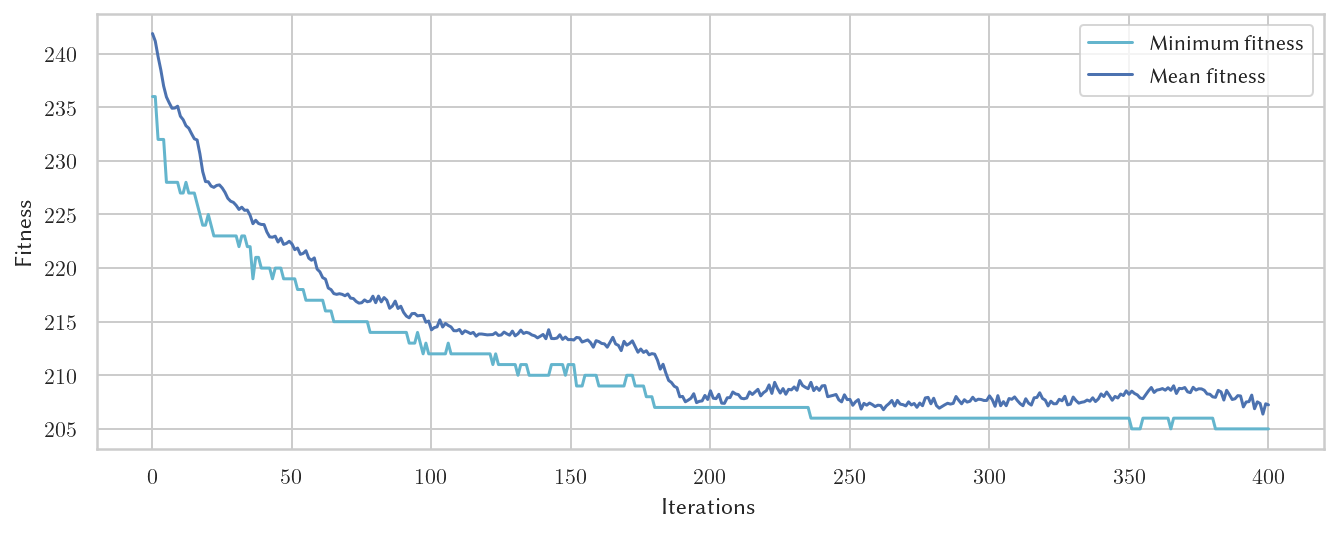

In [24]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### Experimento 3

* Operador de selección: torneo de tamaño 3
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 90%
* Probabilidad de mutación: 5%

In [25]:
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=100)

In [26]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.9, mutpb=0.05,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 7min 8s, sys: 349 ms, total: 7min 9s
Wall time: 7min 16s


In [27]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  202


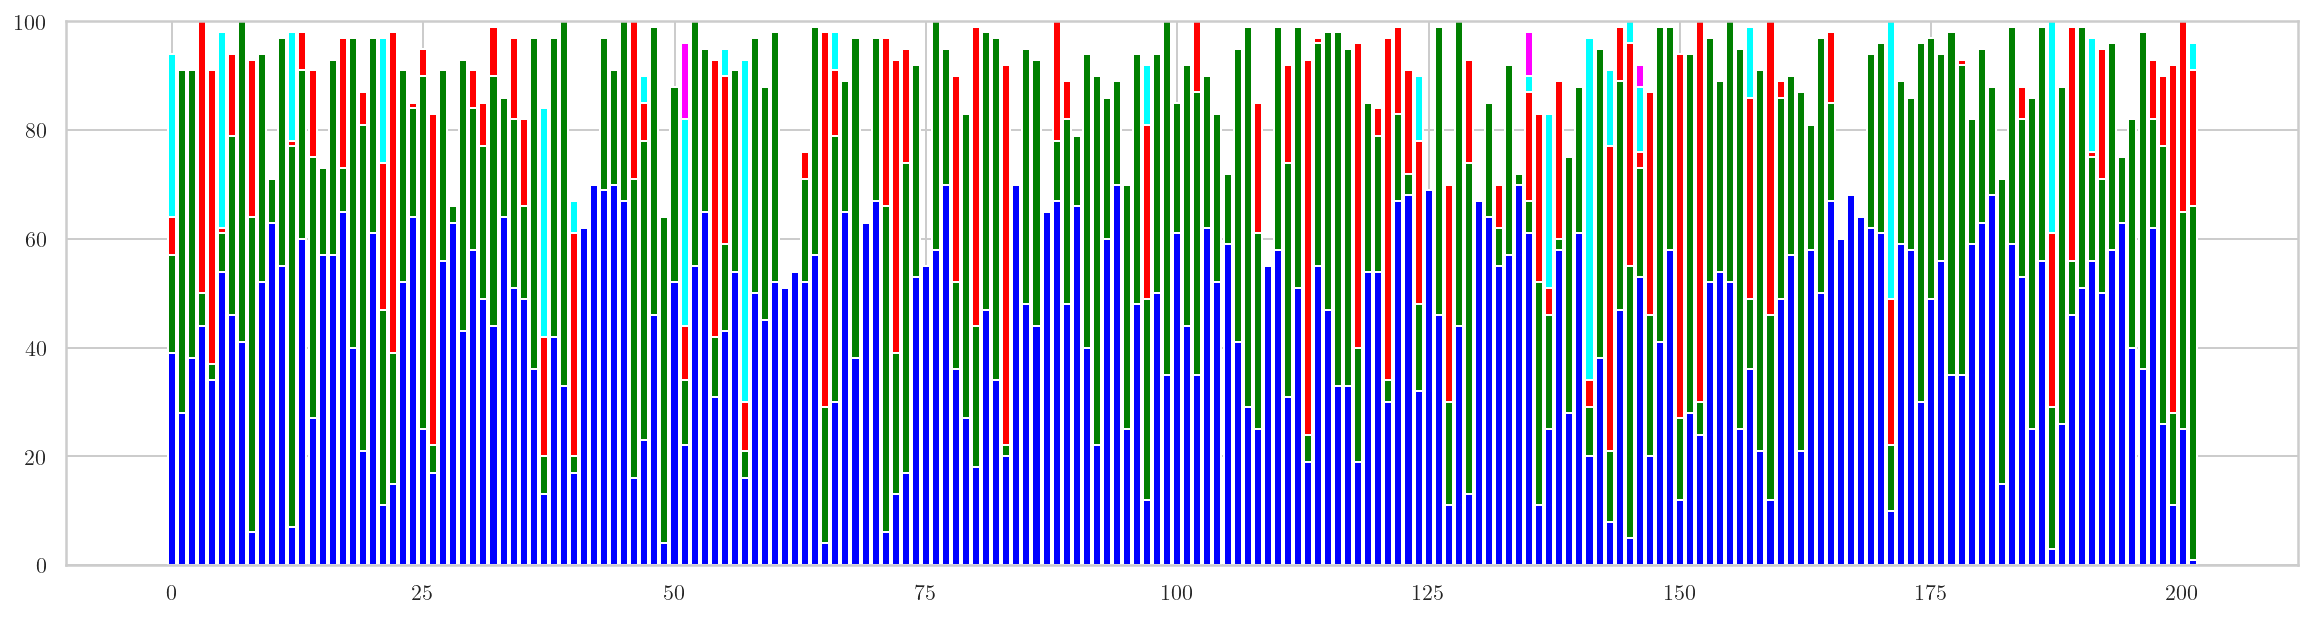

In [28]:
plot_bins(create_bins(best_individual))

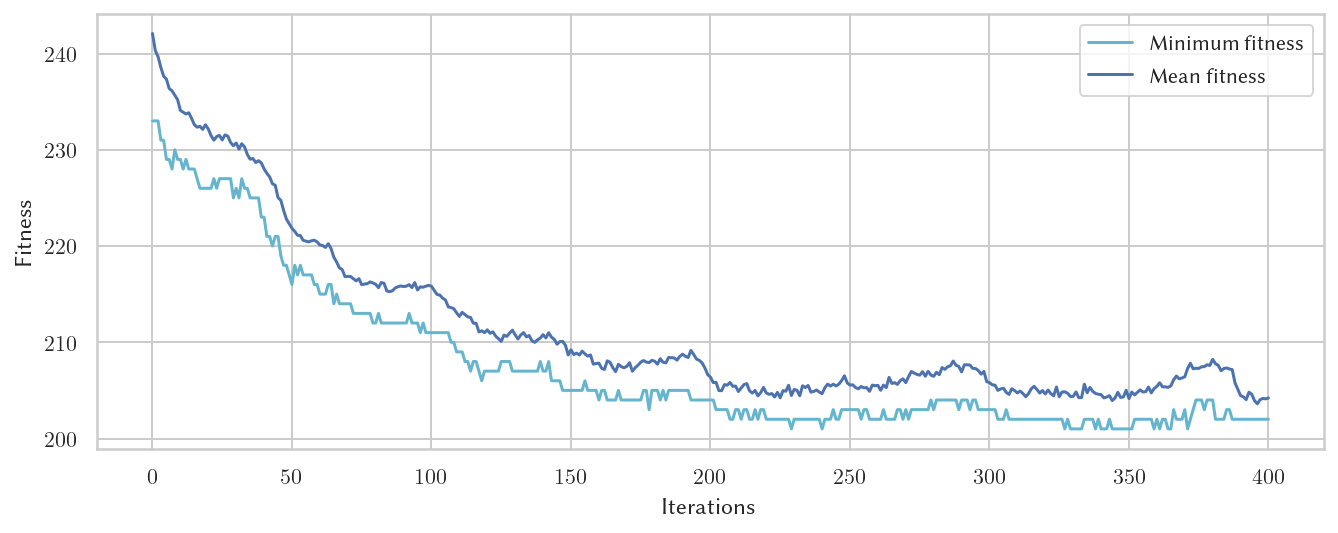

In [29]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### Experimento 4

* Operador de selección: torneo de tamaño 3
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 95%
* Probabilidad de mutación: 5%

In [30]:
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=100)

In [31]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.95, mutpb=0.05,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 7min 37s, sys: 434 ms, total: 7min 38s
Wall time: 7min 43s


In [32]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  210


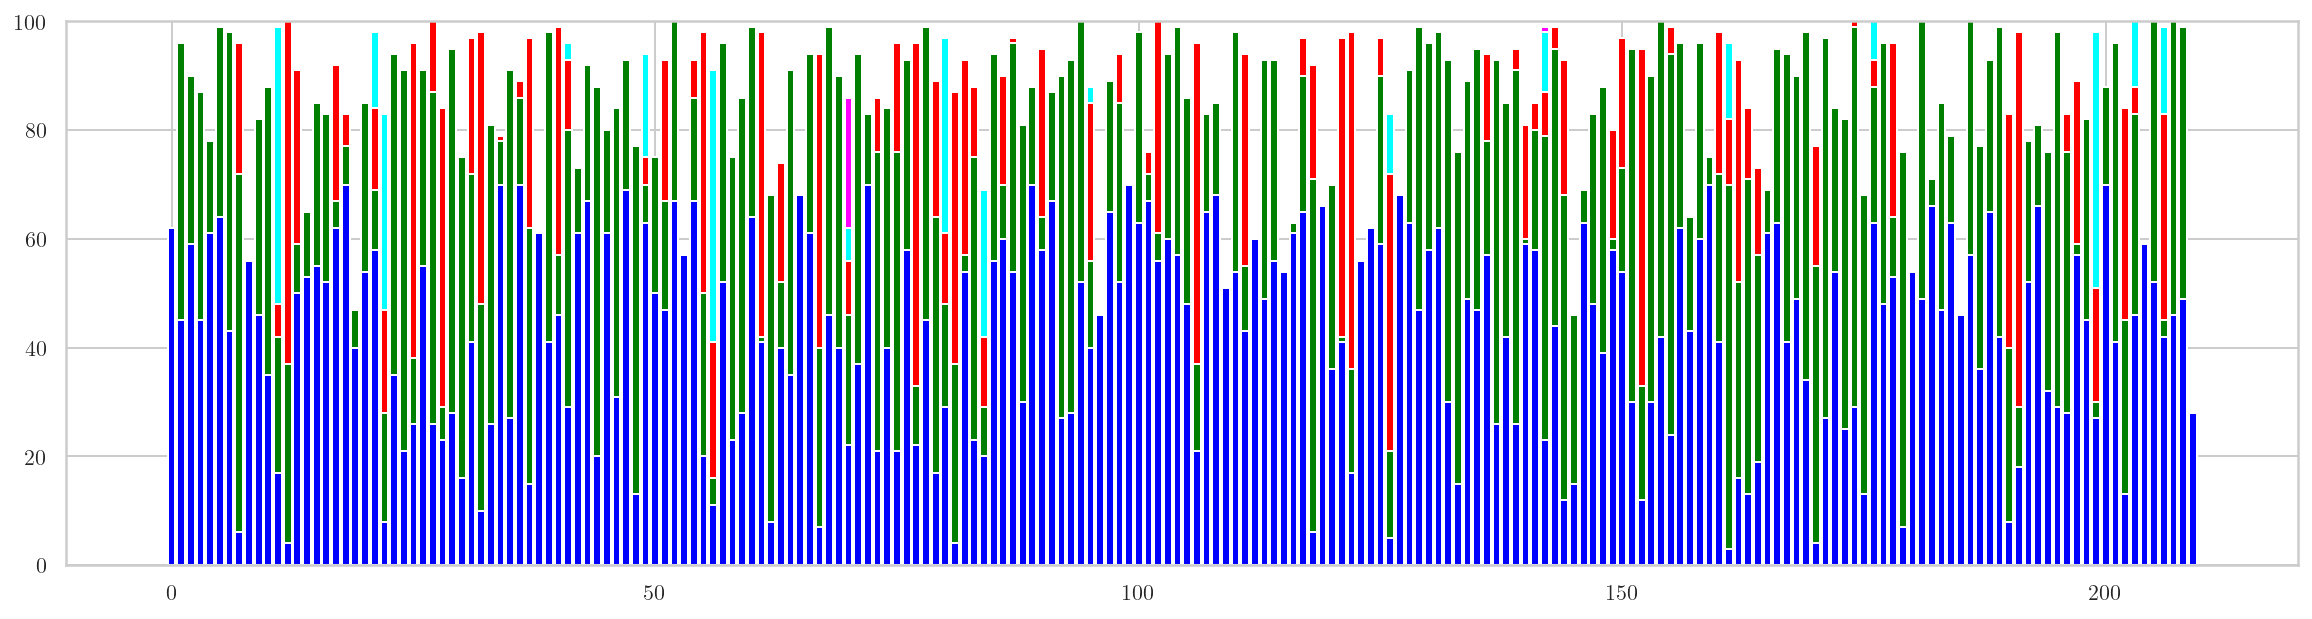

In [33]:
plot_bins(create_bins(best_individual))

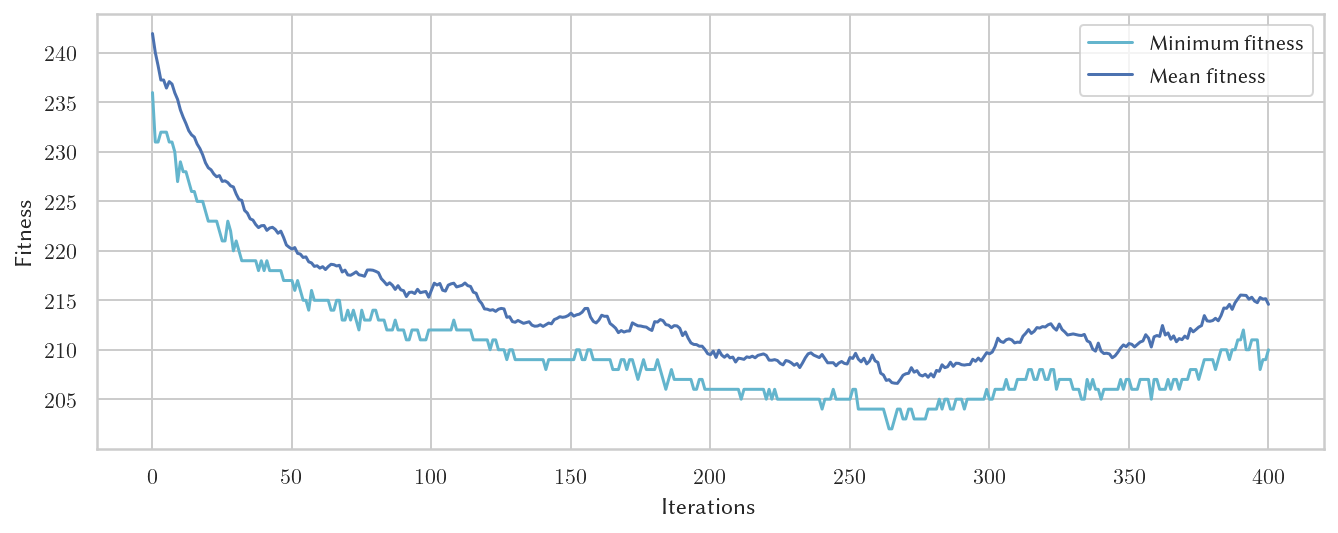

In [34]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### Experimento 5

* Operador de selección: random
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 90%
* Probabilidad de mutación: 5%

In [35]:
toolbox.register("select", tools.selRandom)
pop = toolbox.population(n=100)

In [36]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.9, mutpb=0.05,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 7min 48s, sys: 387 ms, total: 7min 49s
Wall time: 7min 53s


In [37]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  238


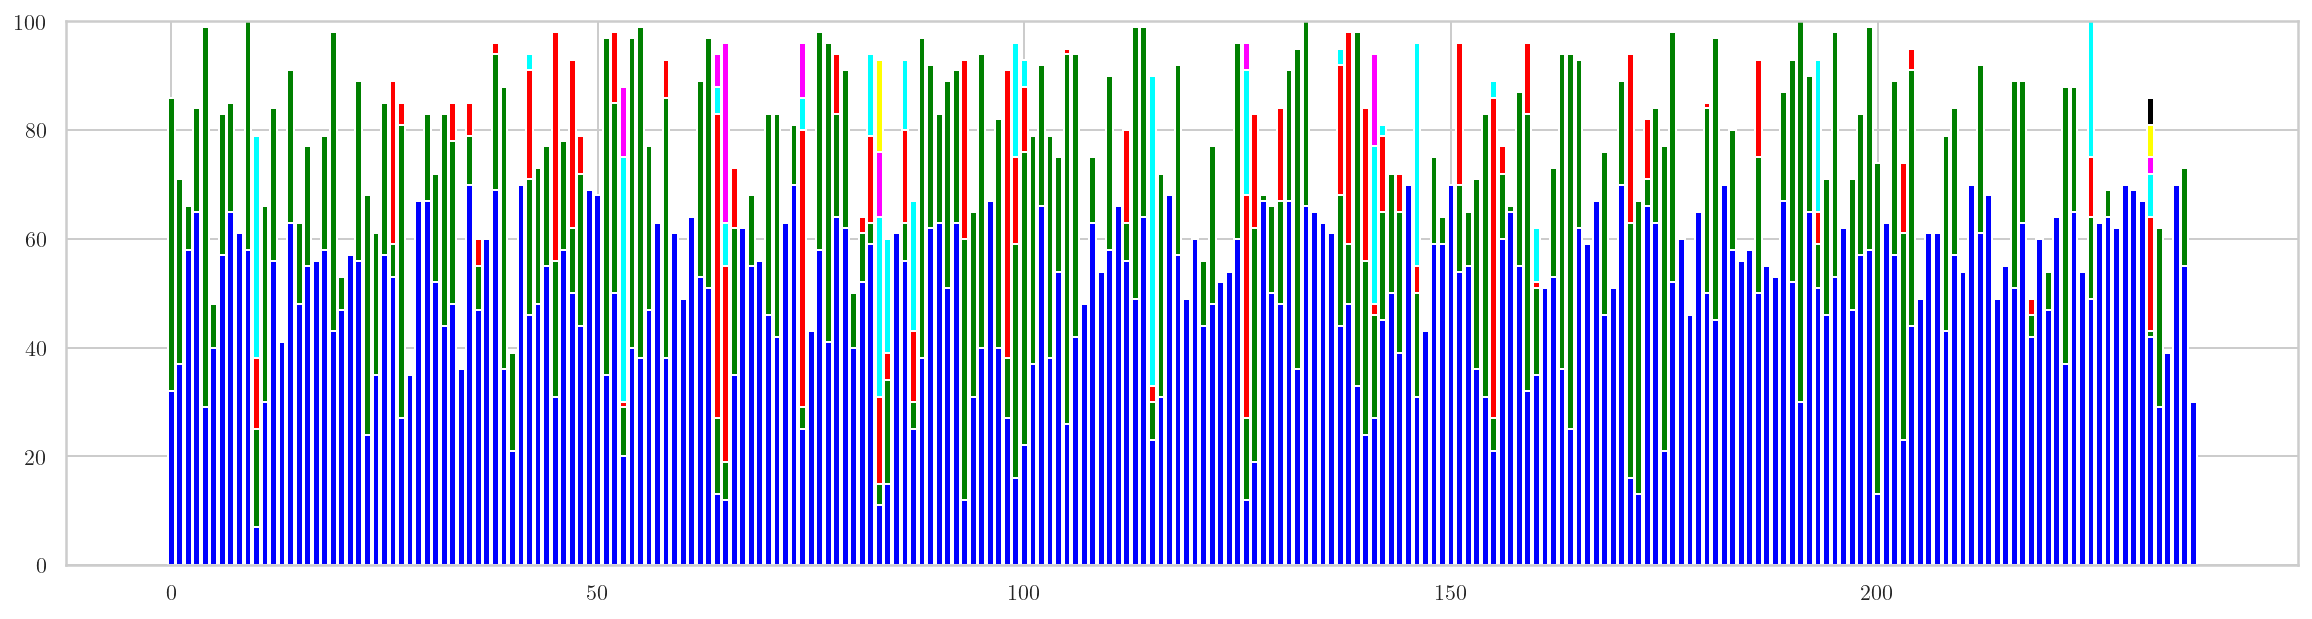

In [38]:
plot_bins(create_bins(best_individual))

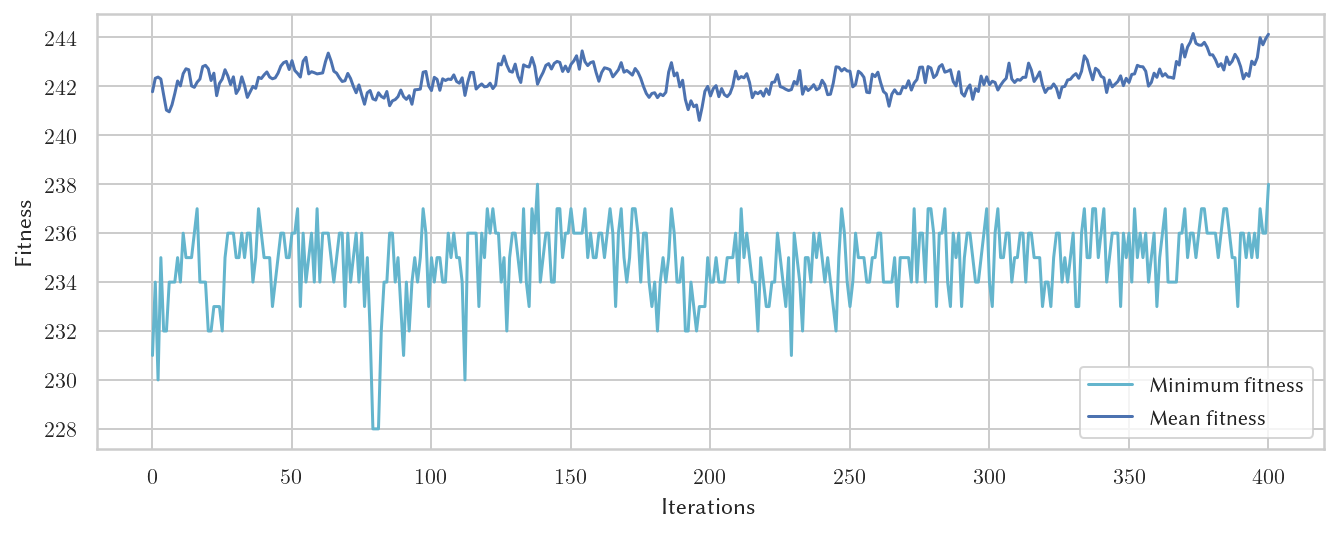

In [39]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### Experimento 6

* Operador de selección: best
* Tamaño de la población: 100
* Número de generaciones: 400
* Probabilidad de cruce: 90%
* Probabilidad de mutación: 5%

In [40]:
toolbox.register("select", tools.selBest)
pop = toolbox.population(n=100)

In [41]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.9, mutpb=0.05,
                             ngen=400, verbose=False,
                             stats=fit_stats)

CPU times: user 7min 57s, sys: 419 ms, total: 7min 57s
Wall time: 8min 2s


In [42]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  235


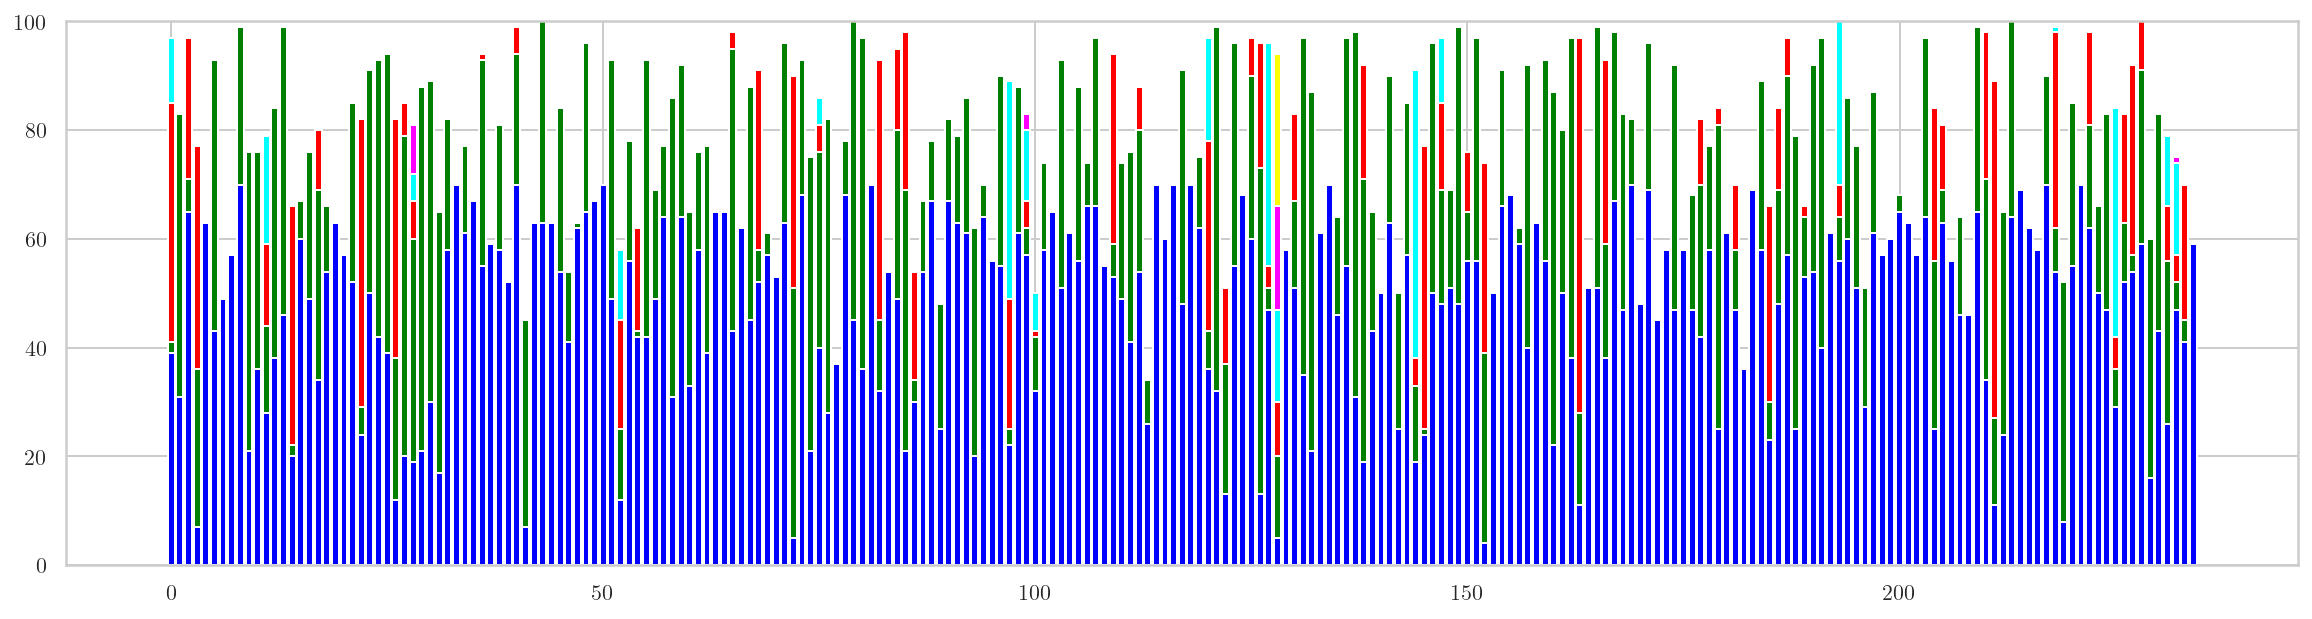

In [43]:
plot_bins(create_bins(best_individual))

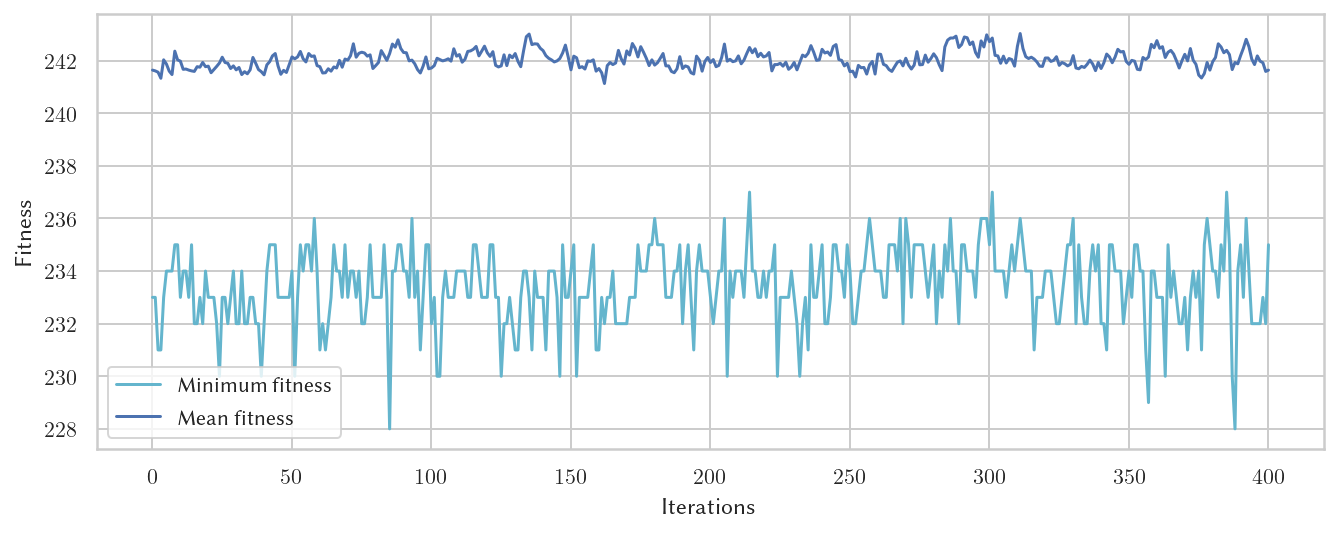

In [44]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

## Experimento 7

* Operador de selección: torneo de tamaño 3
* Tamaño de la población: 150
* Número de generaciones: 500
* Probabilidad de cruce: 90%
* Probabilidad de mutación: 5%

In [45]:
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=150)

In [46]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.9, mutpb=0.05,
                             ngen=500, verbose=False,
                             stats=fit_stats)

CPU times: user 14min 26s, sys: 868 ms, total: 14min 27s
Wall time: 14min 37s


In [47]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  205


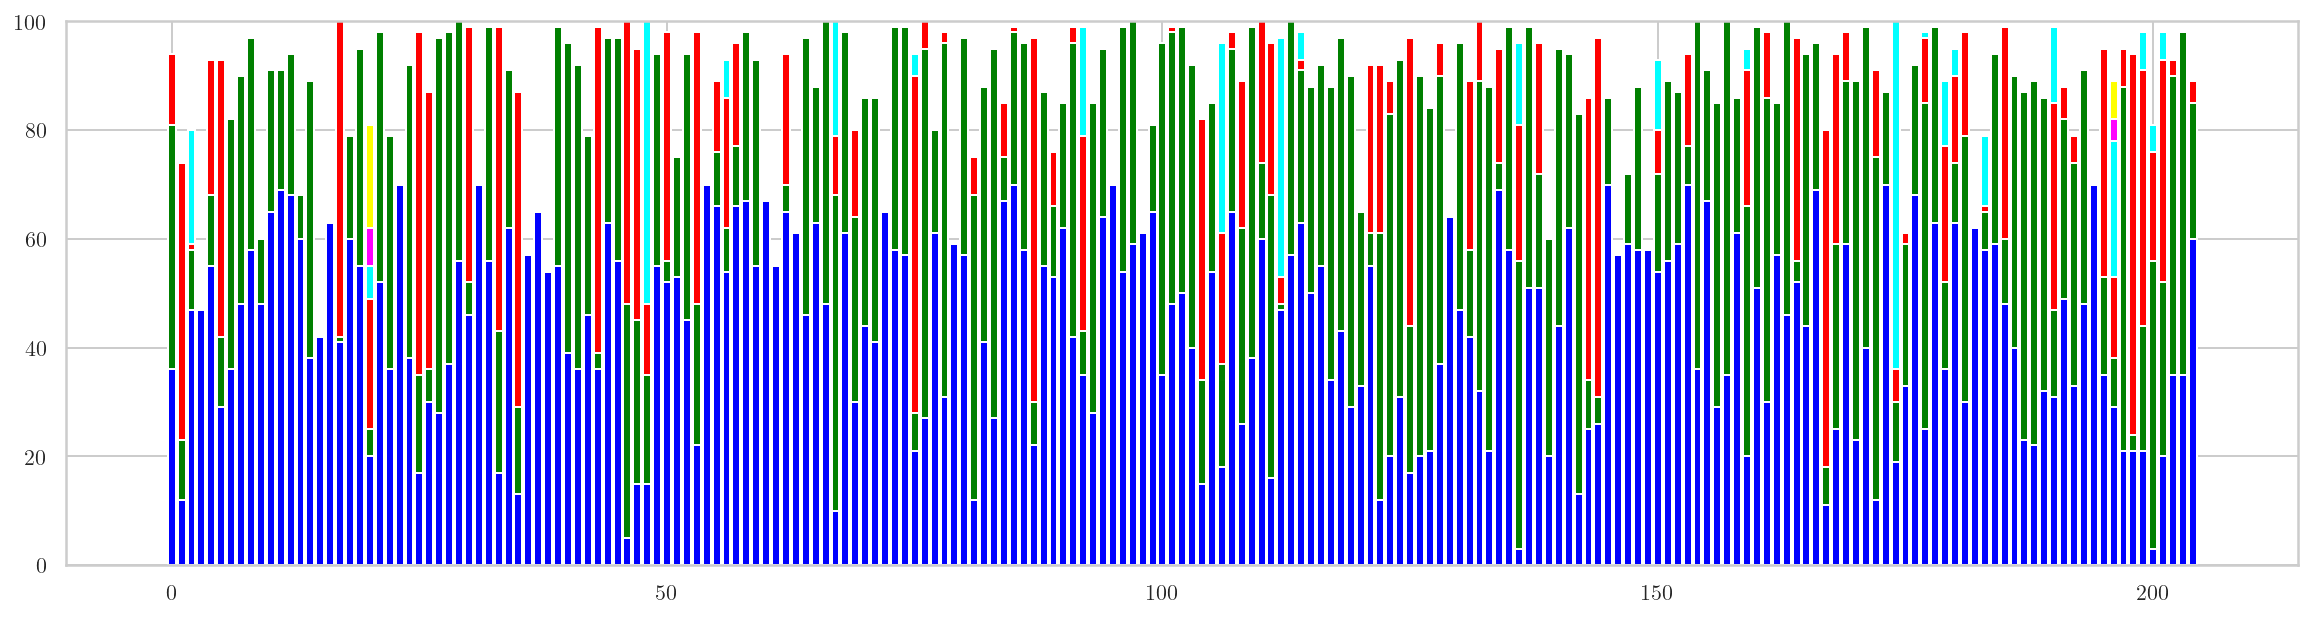

In [48]:
plot_bins(create_bins(best_individual))

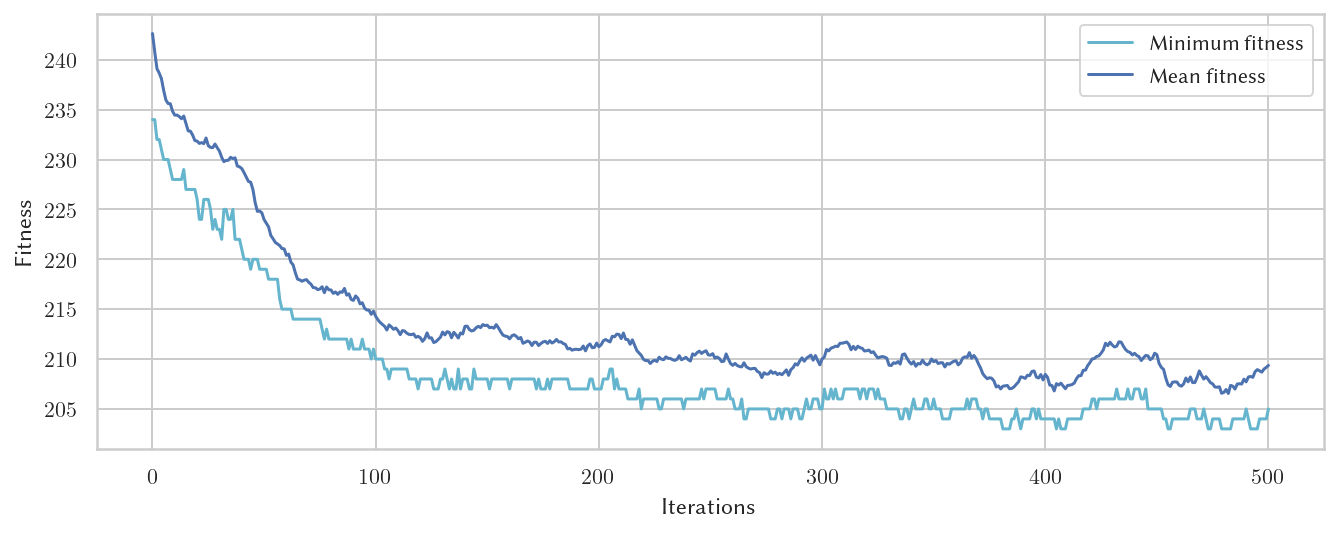

In [49]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

## Enfriamiento simulado

Para la aplicación de enfriamiento simulado al problema, se ha optado por utilizar la librería [simanneal](https://github.com/perrygeo/simanneal).

In [50]:
pip install simanneal

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Proporciona una clase base `Annealer` que hay que extender implementando 2 métodos:

* `move`: define cómo se pasa de una solución existente a una solución vecina
* `energy`: es el fitness de una solución

Desde esta clase también se tiene acceso a la propiedad `self.state`, que representa la solución actual

Dispone de parámetros para ajustar las temperaturas máxima y mínima, el número de iteraciones y la implementación de la copia de estados

In [51]:
from simanneal import Annealer

class BinPackingProblem(Annealer):
    def __init__(self, state, bin_size):
        self.bin_size = bin_size
        super(BinPackingProblem, self).__init__(state) 

    def move(self):
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]
    
    def energy(self):
        bins = place(self.bin_size, self.state)
        return fitness(bins)

### Experimento 1

* Temperatura máxima: 2,500
* Temperatura mínima: 2.5
* Número de iteraciones: 50,000 (default)

In [52]:
bpp = BinPackingProblem(figures, bin_size)
bpp.Tmax = 2500
bpp.Tmin = 2.5
bpp.copy_strategy = "slice"
state, e = bpp.anneal()
print('Fitness of the best found solution: ', e)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Fitness of the best found solution:  230


### Experimento 2

* Temperatura máxima: 100
* Temperatura mínima: 0.05
* Número de iteraciones: 50,000 (default)

In [53]:
bpp = BinPackingProblem(figures, bin_size)
bpp.Tmax = 100
bpp.Tmin = 0.05
bpp.copy_strategy = "slice"
state, e = bpp.anneal()
print('Fitness of the best found solution: ', e)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Fitness of the best found solution:  200


### Experimento 3

* Temperatura máxima: 50
* Temperatura mínima: 0.01
* Número de iteraciones: 50,000 (default)

In [54]:
bpp = BinPackingProblem(figures, bin_size)
bpp.Tmax = 50
bpp.Tmin = 0.01
bpp.copy_strategy = "slice"
state, e = bpp.anneal()
print('Fitness of the best found solution: ', e)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Fitness of the best found solution:  199


### Experimento 4

* Temperatura máxima: 50
* Temperatura mínima: 0.01
* Número de iteraciones: 100,000

In [55]:
bpp = BinPackingProblem(figures, bin_size)
bpp.Tmax = 50
bpp.Tmin = 0.01
bpp.steps = 100000
bpp.copy_strategy = "slice"
state, e = bpp.anneal()
print('Fitness of the best found solution: ', e)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Fitness of the best found solution:  196
